In [1]:
#Imports
#%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    #DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pdpbox
    !pip install shap

# If you're working locally:
else:
    DATA_PATH = '../data/'

import datetime
import pandas as pd
import numpy as np

from category_encoders import OrdinalEncoder, OneHotEncoder

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, mean_absolute_error
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
#Yes today (Regression)
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor
#Not today (Classification)
#Tomorrow, both
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.inspection import permutation_importance
#import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor

import matplotlib.pyplot as plt

In [16]:
#Raw meterorological data
met_readings = pd.read_csv('BW_MET46251.txt', sep=' ', skipinitialspace=True)

#Basically government-made features made out of spectral data
directions = pd.read_csv('BW_SPEC46251.spec.txt', sep=' ', skipinitialspace=True)


def timeFixer(df):
    #first row is weird
    row1 = df.index[0]
    #drop weird first row
    df.drop(df.index[0],inplace=True)
    #add 00 for seconds
    df['ss'] = '00'
    #create date column
    df['Date'] = df['#YY']+'/'+df['MM']+'/'+df['DD']+' '+df['hh']+':'+df['mm']+':'+df['ss']
    #Convert df['Date'] to DateTime object
    #df['Date'] = datetime.datetime.strptime(df['Date'], '%Y/%m/%d %H:%M:%s.%f')
    df['Date'] = pd.to_datetime(df['Date'], format='%Y/%m/%d %H:%M:%S')
    #Index on date
    df.index = df['Date']
    #Drop now uneeded date & time columns
    df.drop(columns=['#YY','MM','DD','hh','mm','ss','Date'],inplace=True)
    #If more than 11 columns, drop extras
    extras = ['WDIR','WSPD','GST','PRES','ATMP','DEWP','VIS','PTDY','TIDE','MWD','WVHT','APD']
    if len(df.columns) > 11:
        df.drop(columns=extras, inplace=True)
    
    return df

met = timeFixer(met_readings)
directions = timeFixer(directions)

new_test1 = pd.read_csv('Test46251.txt', sep=' ', skipinitialspace=True)
new_test2 = pd.read_csv('test2.spec.txt', sep=' ', skipinitialspace=True)
nt1 = timeFixer(new_test1)
nt2 = timeFixer(new_test2)

display(met.head(1))
display(directions.head(1))

combined = pd.concat([met,directions],axis=1)
new_test = pd.concat([nt1,nt2],axis=1)

display(combined.head(2))
print('Combined shape:',combined.shape)
combined = combined.dropna()
new_test = new_test.dropna()
print('Combined shape minus rows with NaNs',combined.shape)

#Convert numericals to floats
numerical_cols = ['WVHT','DPD','WTMP','SwH','SwP','WWH','WWP','APD','MWD']
categorical_cols = ['SwD','WWD','STEEPNESS']
combined[numerical_cols] = combined[numerical_cols].astype('float')
new_test[numerical_cols] = new_test[numerical_cols].astype('float')

combined_comp = combined['STEEPNESS'].value_counts(normalize=True)
most_class = combined['STEEPNESS'].value_counts(normalize=True).max()
print('---')
print('Relative Frequency:',combined_comp)
print('---')
print('Proportion of most common class:',(most_class*100))
#The most common class is 'average' at 58%

#There are 45 days so 27/9/9 split
cutoff_train = '2021-04-01 00:00:00'
cutoff_val = '2021-04-10 00:00:00'
cutoff_test = '2021-04-20 00:00:00'
cutoff_new_test = '2021-4-20 00:00:00'

train = combined.loc[combined.index < cutoff_train]
combined = combined.loc[combined.index > cutoff_train]

val = combined.loc[combined.index < cutoff_val]
combined = combined.loc[combined.index > cutoff_val]

test = combined.loc[combined.index < cutoff_test]

test_new = new_test.loc[new_test.index>cutoff_test]

train_range = [train.index[1],train.index[-1]]
val_range = [val.index[1],val.index[-1]]
test_range = [test.index[1],test.index[-1]]
print('---')
print('Train:',train_range,'Length:',len(train))
print('Val:',val_range,'Length:',len(val))
print('Test:',test_range,'Length:',len(test))
print(len(test_new))

target = 'MWD'
X_train = train.drop(columns=target)
y_train = train[target]

X_val = val.drop(columns=target)
y_val = val[target]

X_test = test.drop(columns=target)
y_test = test[target]

X_new_test = new_test.drop(columns=target)
y_new_test = new_test[target]

print('---')
print('Train:',X_train.shape,y_train.shape,'Val:',X_val.shape,y_val.shape,'Test:',X_test.shape,y_test.shape)

print('---')
baseline_acc = y_train.mean()
y_pred = [y_train.mean()] * len(y_train)
print('Mean Wave Direction:',round(baseline_acc,2))
print('Mean Absolute Error of Naive Regressor:',mean_absolute_error(y_train,y_pred))



,DPD,WTMP
Date,,
2021-04-19 20:26:00,14,16.1


,WVHT,SwH,SwP,WWH,WWP,SwD,WWD,STEEPNESS,APD,MWD
Date,,,,,,,,,,
2021-04-19 20:26:00,1.3,0.7,14.3,1.1,6.7,SSW,W,AVERAGE,5.6,198


,DPD,WTMP,WVHT,SwH,SwP,WWH,WWP,SwD,WWD,STEEPNESS,APD,MWD
Date,,,,,,,,,,,,
2021-03-05 00:26:00,10,14.9,1.1,0.6,12.5,0.9,9.9,W,W,AVERAGE,7.7,276
2021-03-05 00:56:00,11,14.4,1.1,0.6,10.5,0.9,9.9,W,W,AVERAGE,7.5,264


Combined shape: (1786, 12)
Combined shape minus rows with NaNs (1744, 12)
---
Relative Frequency: AVERAGE       0.583142
VERY_STEEP    0.198968
SWELL         0.112385
STEEP         0.105505
Name: STEEPNESS, dtype: float64
---
Proportion of most common class: 58.31422018348624
---
Train: [Timestamp('2021-03-05 00:56:00'), Timestamp('2021-03-31 23:56:00')] Length: 856
Val: [Timestamp('2021-04-01 00:56:00'), Timestamp('2021-04-09 23:56:00')] Length: 419
Test: [Timestamp('2021-04-10 00:56:00'), Timestamp('2021-04-19 20:26:00')] Length: 469
158
---
Train: (856, 11) (856,) Val: (419, 11) (419,) Test: (469, 11) (469,)
---
Mean Wave Direction: 255.24
Mean Absolute Error of Naive Regressor: 26.141649925757708


In [17]:
#Adaptive Boosting Regressor
model_abr = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    AdaBoostRegressor(random_state=42)
)
model_abr.fit(X_train,y_train)

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['SwD', 'WWD', 'STEEPNESS'],
                               use_cat_names=True)),
                ('adaboostregressor', AdaBoostRegressor(random_state=42))])

In [18]:
def check_metrics(model):
    print('---')
    print(model)
    print('Training MAE:', mean_absolute_error(y_train, model.predict(X_train)))
    print('Validation MAE:', mean_absolute_error(y_val, model.predict(X_val)))
    print('Validation R^2:', model.score(X_val,y_val))
    print()
    print()


check_metrics(model_abr)

---
Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['SwD', 'WWD', 'STEEPNESS'],
                               use_cat_names=True)),
                ('adaboostregressor', AdaBoostRegressor(random_state=42))])
Training MAE: 4.937723735251001
Validation MAE: 5.8945584794076025
Validation R^2: 0.9549167976634525




In [19]:
#X_new test prediction of MWD
y_pred = model_abr.predict(X_new_test)
test_mae = mean_absolute_error(y_new_test,model_abr.predict(X_new_test))
test_R2 = model_abr.score(X_new_test,y_new_test)

print(test_mae,test_R2)

5.288878571039399 0.9614769957410216


In [20]:
enc = OneHotEncoder()
encoded_X_train = enc.fit_transform(X_train)
encoded_X_val = enc.fit_transform(X_val)
model_gb_alt = GradientBoostingRegressor()
model_gb_alt.fit(encoded_X_train,y_train)

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


GradientBoostingRegressor()

In [21]:
import shap
row = encoded_X_val.head(1)
explainer = shap.TreeExplainer(model_gb_alt)
shap_values = explainer.shap_values(row)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values,
    features=row
    
)

In [22]:
##Below is tidal stuff

In [23]:
#Working with tides
tides_dates_times = pd.read_csv('BW_MET46251.txt', sep=' ', skipinitialspace=True)
tides = pd.read_csv('9413745.txt',delim_whitespace=True)
test_times_X = X_test.copy()

tides_dates_times['Date'] = tides_dates_times['#YY']+'/'+tides_dates_times['MM']+'/'+tides_dates_times['DD']+' '+tides_dates_times['hh']+':'+tides_dates_times['mm']

#Now I need to convert both time formats into common datetime format expected by prophet, which I'm 
#Hoping to use to infill tidal values, though there is likely a fundamentally more sound way
#To accomplish this.  Tides need to convert to from 24 hour time to datetime.
#from datetime import datetime

tides['Time'] = tides['Day']+' '+tides['Time']
for i in tides.Time:
    tides['a'] = tides['Time'].str[:2].astype('int')
    tides['b'] = tides['Time'].str[3:5].astype('int')
    tides['c'] = tides['Time'].str[-2:]
    tides['d'] = tides['Time']
drop = ['Day','Time']
tides.drop(columns=drop,inplace=True)

a = tides.loc[tides['c']=='PM']
d = a.copy()
d['a'] = d['a']+12
b = tides.loc[tides['c']=='AM']
c = pd.concat([b,d])
#c['dt'] = c.index+' '+c['a'].astype('str').str[0:4]+':'+c['b'].astype('str')+':'+'00'
c['e'] = c.index+' '+c['d']
c['dt'] = pd.to_datetime(c['e'],infer_datetime_format=True)
c.index = c['dt']
drop=['a','b','c','d','dt','e']
c.drop(columns=drop,inplace=True)
c = c.sort_index()
c['time'] = c.index

c['time2'] = c['time'].shift(1)
c['time3'] = (c['time']-c['time2']).astype('timedelta64[h]')
c['Pred2'] = c['Pred'].shift(1)
c['per_dif'] = c['Pred']-c['Pred2']
c['del'] = c['per_dif'] / c['time3']

c.head(1)

,Date,Pred,High/Low,time,time2,time3,Pred2,per_dif,del
dt,,,,,,,,,
2021-03-01 05:27:00,Mon,1.03,L,2021-03-01 05:27:00,NaT,NaN,NaN,NaN,NaN


In [24]:
#To impute tidal data
t = []    
pp = []
p = []
for j in range(1,len(c)):    #For length of tide dataframe
    p = []
    for i in range(1,((c['time3'][j]).astype('int')-1)): #For the number of hours between observations j & j+1
        interval = datetime.timedelta(hours=i) #Add iterating hours
        t.append(c['time2'][j]+interval) #add to list of 6 datetimes
        p.append(abs(c['Pred'][j]+(c['del'][j]-(i)))) #Add prediction (prev pred + i * rate)
    p.reverse()
    pp.extend(p)
data = {'time':t,'Pred':pp}
mp = pd.DataFrame(data)
mp.index = mp['time']
mp.head(10)
cmp = pd.concat([mp,c])

#cmp.sort_index().head(5)

cmp_drop = ['Date','time2','time3','Pred2','per_dif','del']
cmp.drop(columns=cmp_drop,inplace=True)
cmp['day'] = cmp.index.day
cmp['time'] = cmp.index.hour
cmp = cmp.sort_values(['day','time'],ascending=[True,True])
cmp = cmp.reset_index()
cmp.head(1)

,index,time,Pred,High/Low,day
0,2021-03-01 05:27:00,5,1.03,L,1


In [25]:
c_drop = ['time']
c.drop(columns=c_drop,inplace=True)
c['day'] = c.index.day
c['time'] = c.index.hour
c = c.reset_index()
c
ccmp = pd.concat([cmp,c])
ccmp = ccmp.sort_values(['day','time'],ascending=[True,True])
ccmp.reset_index()

ccmp['key'] = (ccmp['time']).astype('str') + (ccmp['day']).astype('str')
ccmp.drop(columns=['High/Low','dt','Date','time2','time3','Pred2','per_dif','del'],inplace=True)
ccmp.dropna(inplace=True)
ccmp.head(1)

,index,time,Pred,day,key
0,2021-03-01 05:27:00,5,1.03,1,51


In [55]:
#I've imputed my tidal data, now I'll combine it into my df
#I'll just make a copy of the old one
X_train_tides = train.copy()
y_train_tides = train.copy()

X_train_tides['time'] = X_train_tides.index.hour
X_train_tides['day'] = X_train_tides.index.day
X_train_tides['key'] = (X_train_tides['time']).astype('str') + (X_train_tides['day']).astype('str')

X_train_tides_c = pd.merge(X_train_tides,ccmp,on='key',how='inner')
X_train_tides_c.drop_duplicates(inplace=True)
X_train_tides_c.index = X_train_tides_c['index']
X_train_tides_c.drop(columns=['time_x','day_x','key','index','time_y','day_y'],inplace=True)
print(X_train_tides_c.shape)


X_train_tides_c = X_train_tides_c.drop_duplicates(subset='Pred',keep='first')
X_train_tides_c.sort_index().head(5)

(714, 13)


,DPD,WTMP,WVHT,SwH,SwP,WWH,WWP,SwD,WWD,STEEPNESS,APD,MWD,Pred
index,,,,,,,,,,,,,
2021-03-01 12:27:00,6.0,12.8,2.5,1.1,13.3,2.3,6.2,W,WNW,VERY_STEEP,6.0,290.0,4.686667
2021-03-02 12:25:00,6.0,12.9,2.2,0.7,11.8,2.1,6.2,W,WNW,VERY_STEEP,5.8,288.0,4.260000
2021-03-02 22:24:00,6.0,12.9,2.1,0.7,10.5,2.0,5.6,W,WNW,VERY_STEEP,5.7,290.0,4.738333
2021-03-03 22:02:00,6.0,13.1,2.2,0.6,16.7,2.2,5.6,SW,WNW,VERY_STEEP,5.5,292.0,3.768333
2021-03-04 12:41:00,6.0,12.8,2.0,0.6,15.4,2.0,6.2,S,W,VERY_STEEP,5.3,275.0,2.673333


In [43]:
X_test_tides

,Date,DPD,WTMP,WVHT,SwH,SwP,WWH,WWP,SwD,WWD,STEEPNESS,APD,dam,hour,day,key
0,2021-04-10 00:26:00,6.0,14.1,1.9,0.5,14.3,1.9,5.9,S,WNW,VERY_STEEP,5.1,2021-04-10 00:26:00,0,10,100
1,2021-04-10 00:56:00,6.0,14.1,1.9,0.4,14.3,1.9,6.2,S,W,VERY_STEEP,5.0,2021-04-10 00:56:00,0,10,100
2,2021-04-10 01:26:00,8.0,14.0,2.0,0.3,14.3,2.0,7.7,S,W,STEEP,5.1,2021-04-10 01:26:00,1,10,101
3,2021-04-10 01:56:00,6.0,14.0,2.1,0.4,14.3,2.0,5.9,SW,WNW,VERY_STEEP,5.1,2021-04-10 01:56:00,1,10,101
4,2021-04-10 02:26:00,6.0,14.0,2.0,0.4,10.5,2.0,6.2,WSW,WNW,VERY_STEEP,5.2,2021-04-10 02:26:00,2,10,102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
464,2021-04-19 18:26:00,14.0,16.6,1.2,0.7,14.3,1.0,7.1,SSW,W,AVERAGE,6.2,2021-04-19 18:26:00,18,19,1918
465,2021-04-19 18:56:00,14.0,16.5,1.2,0.8,14.3,0.9,5.3,SSW,W,AVERAGE,6.7,2021-04-19 18:56:00,18,19,1918
466,2021-04-19 19:26:00,20.0,16.4,1.2,0.7,20.0,1.0,6.7,SW,W,AVERAGE,6.1,2021-04-19 19:26:00,19,19,1919
467,2021-04-19 19:56:00,20.0,16.3,1.2,0.7,20.0,1.0,7.7,SW,W,AVERAGE,6.1,2021-04-19 19:56:00,19,19,1919


In [47]:

X_test_tides = test.copy()
X_test_tides['dam'] = X_test_tides.index
X_test_tides['hour'] = X_test_tides['dam'].dt.hour
X_test_tides['day'] = X_test_tides['dam'].dt.day
X_test_tides['key'] = (X_test_tides['day']).astype('str') + (X_test_tides['hour']).astype('str')
X_test_tides = X_test_tides.reset_index()

tides_test_raw = pd.read_csv('24hr9413745.txt',delim_whitespace=True)
tides_test_raw['both'] = tides_test_raw['Date']+' '+tides_test_raw['Time']
tides_test_raw['both'] = pd.to_datetime(tides_test_raw['both'])
tides_test_raw['both2'] = tides_test_raw['both'].shift(1)
tides_test_raw['time3'] = tides_test_raw['both'] - tides_test_raw['both2']
tides_test_raw['time3'] = (pd.to_numeric(tides_test_raw['time3'].dt.seconds,downcast='integer')/3600)
tides_test_raw = tides_test_raw[1:]
tides_test_raw['time3'] = round(tides_test_raw['time3'],0).astype('int')
tides_test_raw['day'] = tides_test_raw['both'].dt.day
tides_test_raw['Pred2'] = tides_test_raw['Pred'].shift(1)
tides_test_raw['dif'] = tides_test_raw['Pred'] - tides_test_raw['Pred2']
tides_test_raw['vel'] = tides_test_raw['dif'] / tides_test_raw['time3']
tides_test_raw['day'] = tides_test_raw['both'].dt.day
tides_test_raw['hour'] = tides_test_raw['both'].dt.hour
tides_test_raw['key'] = tides_test_raw['day'].astype('str')+tides_test_raw['hour'].astype('str')
tides_test_raw


#To impute tidal data
t = []    
pp = []
p = []
for j in range(1,len(tides_test_raw)):    #For length of tide dataframe
    p = []
    for i in range(1,((tides_test_raw['time3'][j]).astype('int')-1)): #For the number of hours between observations j & j+1
        interval = datetime.timedelta(hours=i) #Add iterating hours
        t.append(tides_test_raw['both2'][j]+interval) #add to list of 6 datetimes
        p.append(abs(tides_test_raw['Pred'][j]+(tides_test_raw['vel'][j]-(i)))) #Add prediction (prev pred + i * rate)
    p.reverse()
    pp.extend(p)
data = {'time':t,'Pred':pp}
mp_test = pd.DataFrame(data) 
mp_test.index = mp_test['time']  #I know this worked
#I need to now combine these predictions with my test_set

mp_test
mp_test['day'] = mp_test.index.day
mp_test['hour'] = mp_test.index.hour
mp_test['key'] = mp_test['day'].astype('str')+mp_test['hour'].astype('str')
mp_test.drop(columns=['time','day','hour'],inplace=True)
mp_test = mp_test.reset_index()
mp_test.drop(columns='time',inplace=True)
mp_test.head(10)

,Pred,key
0,NaN,105
1,NaN,106
2,NaN,107
3,NaN,108
4,4.181667,1011
5,3.181667,1012
6,2.181667,1013
7,1.181667,1014
8,1.221667,1017
9,2.221667,1018


In [45]:
test_tides = pd.merge(left=mp_test,right=X_test_tides,on='key')
test_tides = test_tides.drop_duplicates(subset='Pred',keep='first')
test_tides['Index'] = test_tides['Date']
holder = test_tides['Pred']
test_tides.index = test_tides['Index']
test_tides['Pred2'] = test_tides['Pred']
test_tides.drop(columns=['Date','key','dam','hour','day','Pred','Index'],inplace=True)
test_tides['Pred'] = test_tides['Pred2']
test_tides.drop(columns=['Pred2'],inplace=True)
test_tides.head(5)

,DPD,WTMP,WVHT,SwH,SwP,WWH,WWP,SwD,WWD,STEEPNESS,APD,MWD,Pred
Index,,,,,,,,,,,,,
2021-04-10 05:26:00,7.0,13.9,2.1,0.5,13.3,2.0,6.7,SW,W,STEEP,5.6,276.0,NaN
2021-04-10 11:26:00,6.0,14.0,1.9,0.4,11.1,1.9,5.9,W,WNW,VERY_STEEP,5.4,283.0,4.181667
2021-04-10 12:26:00,7.0,14.1,2.0,0.4,10.5,2.0,6.7,WNW,W,STEEP,5.3,279.0,3.181667
2021-04-10 13:26:00,6.0,14.1,2.1,0.4,13.3,2.1,5.9,S,WNW,VERY_STEEP,5.3,286.0,2.181667
2021-04-10 14:26:00,7.0,14.1,2.1,0.4,10.5,2.1,7.1,W,W,STEEP,5.4,269.0,1.181667


In [54]:
#Now that I've finally fitted in my tidal data, I don't really want to do the same thing
#For the validation and test sets.  I could probably do them together (data leak?)
#What I should do is make an advanced wrangle function that does all the steps automatically
#It woudln't even take that long

#For now, I'm going to focus on some visualizations to satisfy the project constraints
X_train_tides_c

,DPD,WTMP,WVHT,SwH,SwP,WWH,WWP,SwD,WWD,STEEPNESS,APD,Pred
index,,,,,,,,,,,,
2021-03-05 02:32:00,10.0,13.8,1.1,0.6,10.5,0.9,9.9,W,W,AVERAGE,7.3,5.170000
2021-03-05 03:32:00,11.0,13.8,1.0,0.5,11.1,0.9,9.1,WSW,W,AVERAGE,6.6,5.612857
2021-03-05 04:32:00,13.0,13.8,1.0,0.6,12.5,0.9,9.9,WSW,W,AVERAGE,6.5,4.612857
2021-03-05 05:32:00,13.0,13.7,1.1,0.6,12.5,0.9,8.3,WSW,W,AVERAGE,6.3,3.612857
2021-03-05 06:32:00,11.0,13.7,1.0,0.6,10.5,0.8,9.9,W,W,AVERAGE,6.0,2.612857
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-31 13:38:00,15.0,13.3,0.9,0.5,15.4,0.7,7.7,SW,W,AVERAGE,7.0,3.850000
2021-03-31 14:38:00,17.0,13.2,1.0,0.6,16.7,0.8,9.1,SSW,W,AVERAGE,7.5,1.946000
2021-03-31 15:38:00,12.0,13.2,0.9,0.6,11.8,0.7,9.9,WNW,WNW,AVERAGE,7.1,0.946000


In [14]:
from sklearn.model_selection import GridSearchCV

In [56]:
#My test set is
test_model2 = test_tides.copy()
test_model2 = test_model2[1:]
#My training set is 
train_model2 = X_train_tides_c.copy()

target = 'MWD'

y_train_tides_c = train_model2[target]
X_train_tides_c = train_model2.drop(columns=target)

y_test_tides = test_model2[target]
X_test_tides = test_model2.drop(columns=target)

print(X_train_tides_c.shape,y_train_tides_c.shape,X_test_tides.shape,y_test_tides.shape)

(341, 12) (341,) (148, 12) (148,)


In [136]:
baseline = [y_train_tides_c.mean()] * len(y_train_tides_c)
set_2_baseline_acc = mean_absolute_error(baseline,y_train_tides_c)
set_2_baseline_acc*100

40.87529347012839

In [57]:
ridge_params = {'ridge__alpha':[.01,.20,.30,.40,.50,.60,.70,.80,.90]
}

model_r = make_pipeline(
    OrdinalEncoder(),
    Ridge()
)

grid_ridge = GridSearchCV(model_r,
                          param_grid=ridge_params
    
                         ).fit(X_train_tides_c,y_train_tides_c)

y_pred_ridge = grid_ridge.best_estimator_.predict(X_train_tides_c)

print('MAE Ridge Train:',mean_absolute_error(y_train_tides_c,y_pred_ridge))

MAE Ridge Train: 10.49120634546714


In [58]:
#I need a linear model and a tree based model
#RandomForestRegressor and Ridge
rf_params = {'randomforestregressor__n_estimators':[75,100,150,200,250,300],
             'randomforestregressor__bootstrap':[True,False],
             'randomforestregressor__warm_start':[True,False],
             'randomforestregressor__max_depth':[1,2,4,10,20,50,100],
             'randomforestregressor__n_jobs':[-1]
    
}

model_rf = make_pipeline(
    OrdinalEncoder(),
    RandomForestRegressor()
)

grid_forest = GridSearchCV(model_r,
                          param_grid=ridge_params).fit(X_train_tides_c,y_train_tides_c)
y_pred_rf = grid_forest.best_estimator_.predict(X_train_tides_c)
y_pred_rf_test = grid_forest.best_estimator_.predict(X_test_tides)
print('MAE Forest Train:',mean_absolute_error(y_test_tides,y_pred_rf_test))

MAE Forest Train: 12.353983569346921


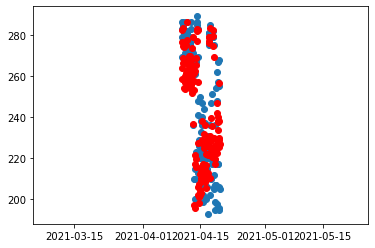

In [59]:
plt.scatter(y_test_tides.index,y_test_tides)

plt.scatter(y_test_tides.index,y_pred_rf_test,color='red')

In [38]:
X_train_tides

,DPD,WTMP,WVHT,SwH,SwP,WWH,WWP,SwD,WWD,STEEPNESS,APD,time,day,key
Date,,,,,,,,,,,,,,
2021-03-05 00:26:00,10.0,14.9,1.1,0.6,12.5,0.9,9.9,W,W,AVERAGE,7.7,0,5,05
2021-03-05 00:56:00,11.0,14.4,1.1,0.6,10.5,0.9,9.9,W,W,AVERAGE,7.5,0,5,05
2021-03-05 01:26:00,11.0,14.0,1.1,0.6,11.1,0.9,7.7,W,WSW,AVERAGE,7.3,1,5,15
2021-03-05 01:56:00,10.0,13.8,1.1,0.5,11.8,1.0,9.9,WSW,WSW,AVERAGE,7.3,1,5,15
2021-03-05 02:26:00,10.0,13.8,1.1,0.6,10.5,0.9,9.9,W,W,AVERAGE,7.3,2,5,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-31 20:56:00,17.0,14.0,0.9,0.6,16.7,0.7,9.9,SSW,W,AVERAGE,8.4,20,31,2031
2021-03-31 21:26:00,18.0,14.1,0.9,0.6,18.2,0.7,9.1,SSW,W,AVERAGE,8.2,21,31,2131
2021-03-31 21:56:00,17.0,14.1,0.9,0.6,16.7,0.7,9.9,SSW,W,AVERAGE,7.9,21,31,2131


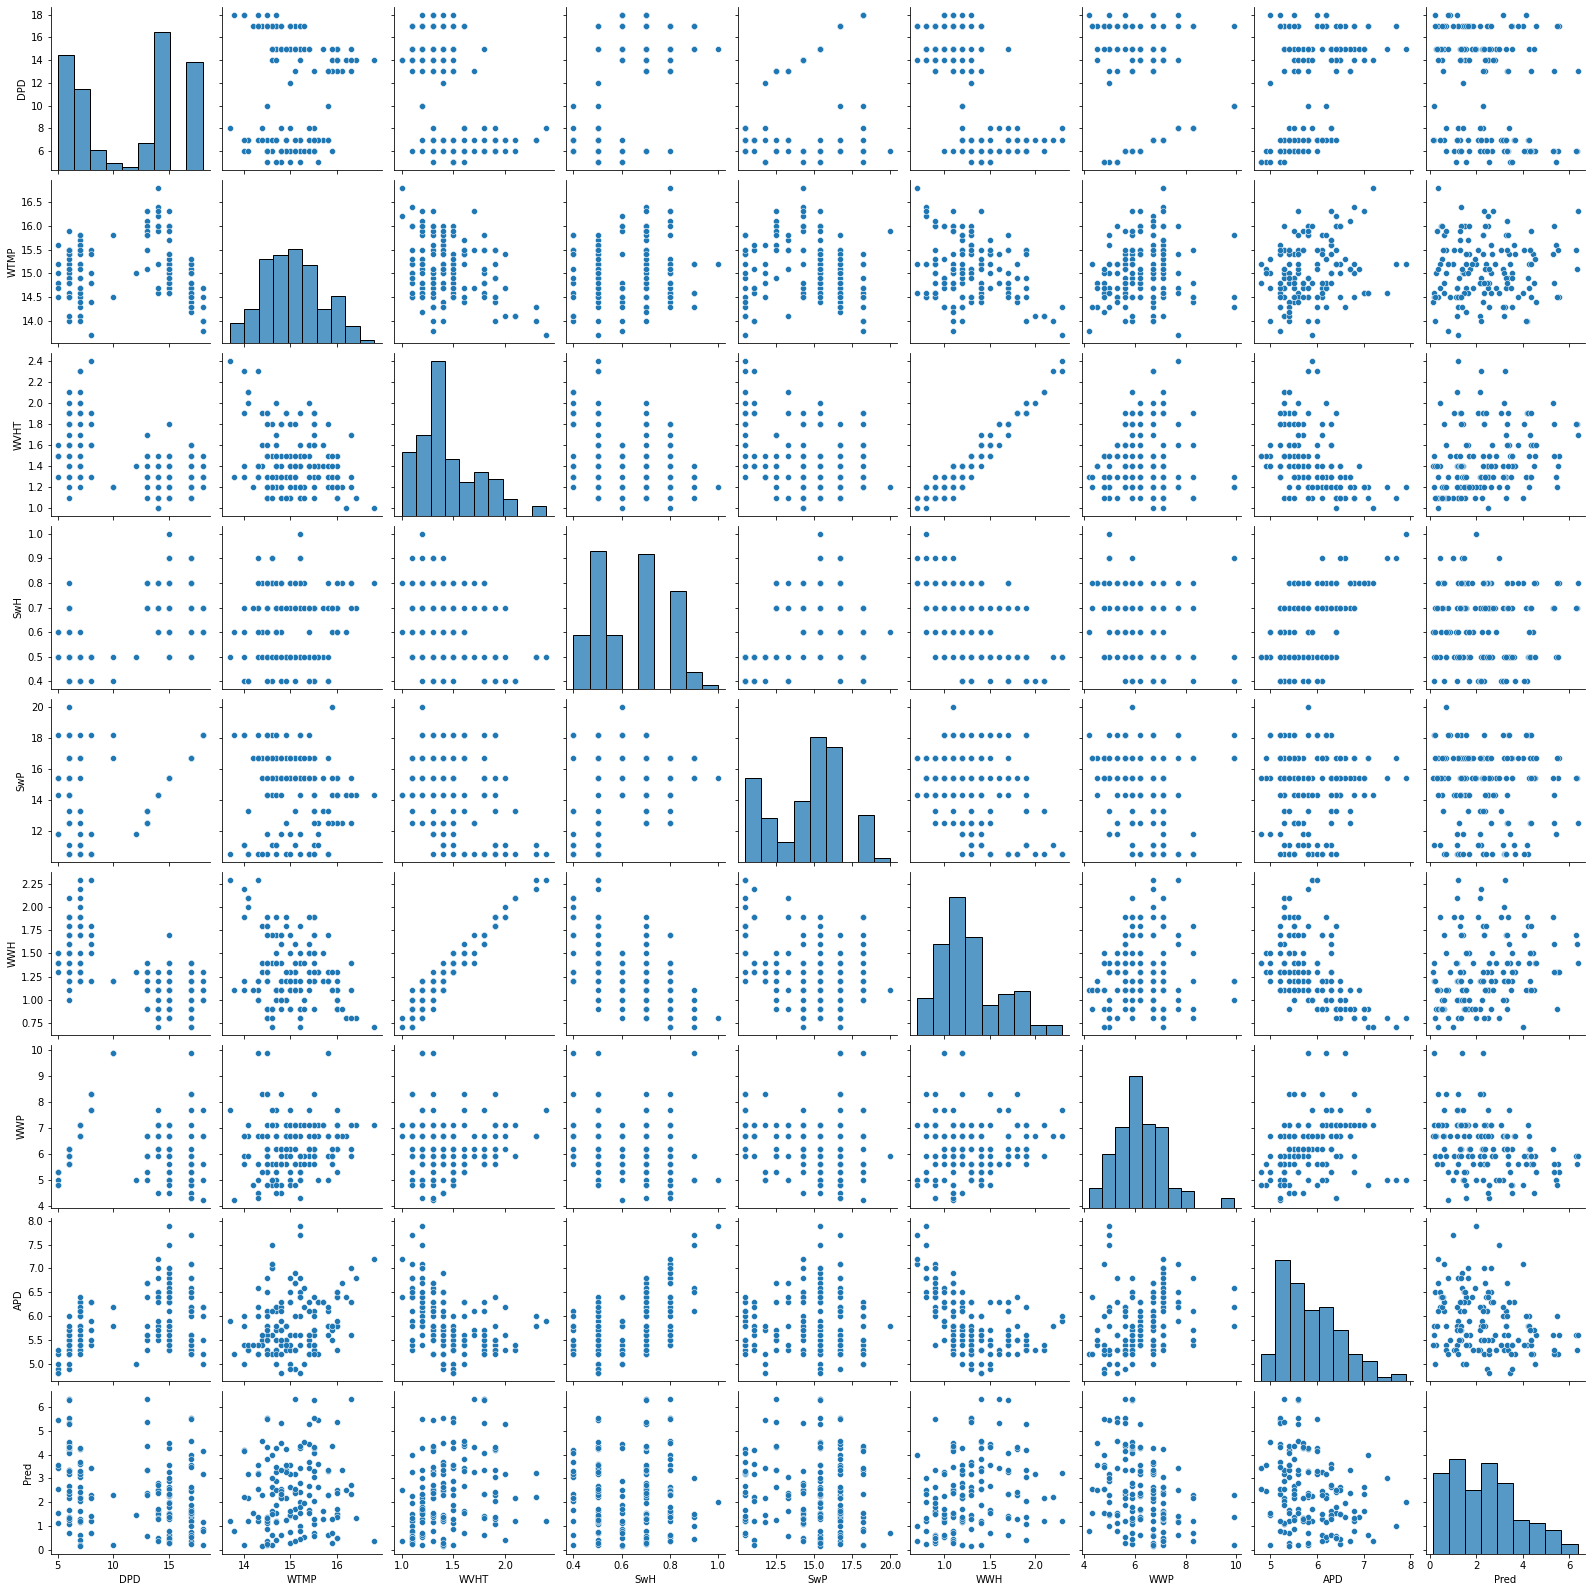

In [183]:
import seaborn as sns
sns.pairplot(test_model2)

In [160]:
import shap

In [60]:
enc = OneHotEncoder()
encoded_X_test = enc.fit_transform(X_test_tides)
model_rf_alt = RandomForestRegressor()
model_rf_alt.fit(encoded_X_test,y_test_tides)

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


RandomForestRegressor()

In [61]:
row = encoded_X_test.iloc[70]
explainer = shap.TreeExplainer(model_rf_alt)
shap_values = explainer.shap_values(row)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values,
    features=row
)